In [37]:
from pathlib import Path

base_path = Path("../data/Protera") 

!ls $base_path

clustering     prism			       stability_test.h5
cluster.out    search.out		       stability_train.csv
data.csv       sequences.fasta		       stability_train.h5
mmseq	       stability.csv		       stability_with_dups.csv
mmseq_q        stability_embeddings_test.pkl   tmp
mmseq_t        stability_embeddings_train.pkl
prefilter.out  stability_test.csv



## Original set and new train/test split

In [40]:
import pandas as pd
import numpy as np

def train_test_split(dataset, test_size=None):
    dataset_size = len(dataset)
    dataset_indices = list(range(dataset_size))

    np.random.shuffle(dataset_indices)

    if test_size is not None:
        test_split_index = int(test_size)
    else:
        test_split_index = int(np.floor((1 - 0.8) * dataset_size))

    train_idx, test_idx = (
        dataset_indices[test_split_index:],
        dataset_indices[:test_split_index],
    )

    dataset_train = dataset.iloc[train_idx, :]
    dataset_test = dataset.iloc[test_idx, :]

    return dataset_train, dataset_test

dataset = pd.read_csv(base_path / "stability.csv")
dataset = dataset.drop_duplicates()
dataset["sequences"] = dataset["sequences"].astype("str")
dataset = dataset[dataset["sequences"].str.len() < 1000]

dataset_train = pd.read_csv(base_path / "stability_train.csv")
dataset_test = pd.read_csv(base_path / "stability_test.csv")

## Subset

> We will use only 9k random samples because of space and GPU constraints.

In [29]:
# THIS WAS ALREADY DONE
# _, subset = train_test_split(dataset, 9e3)
# dataset_train, dataset_test = train_test_split(subset)
# dataset_train, dataset_test = dataset_train[dataset_train.columns[::-1]], dataset_test[dataset_test.columns[::-1]]
# dataset_train.to_csv(base_path / "stability_train.csv", index=False)
# dataset_test.to_csv(base_path / "stability_test.csv", index=False)

In [34]:
from protera_stability.data import ProteinStabilityDataset
from protera_stability.utils import dim_reduction
from pathlib import Path
import matplotlib.pyplot as plt

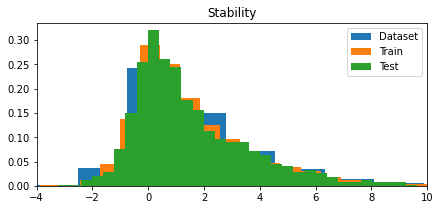

In [47]:
f, axs = plt.subplots(figsize=(7,3))

y = dataset.labels
y_train = dataset_train.labels
y_test = dataset_test.labels

axs.hist(y, bins=50, label="Dataset", density=True)
axs.hist(y_train, bins=50, label="Train", density=True)
axs.hist(y_test, bins=50, label="Test", density=True)
axs.set_title("Stability")
axs.legend()
plt.xlim([-4, 10])
plt.show()

## Check diversity

In [49]:
diversity_train = pd.read_csv(base_path / "stability_train_diversity.csv")
diversity_test = pd.read_csv(base_path / "stability_test_diversity.csv")

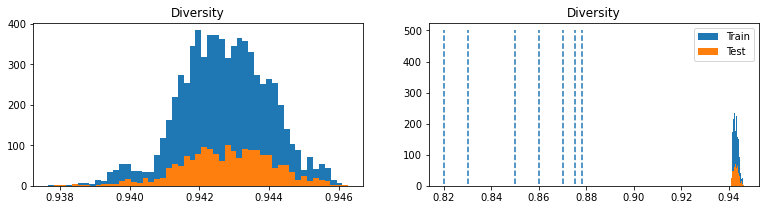

In [51]:
# diversity_dset_sorted = diversity_dset.sort_values(by="diversity", ascending=True)
diversity_train_sorted = diversity_train.sort_values(by="diversity", ascending=True)
diversity_test_sorted = diversity_test.sort_values(by="diversity", ascending=True)

f, axs = plt.subplots(ncols=2, figsize=(13,3))

# axs[0].hist(diversity_dset_sorted.diversity, bins=50, label="Dataset")
axs[0].hist(diversity_train_sorted.diversity, bins=50, label="Train")
axs[0].hist(diversity_test_sorted.diversity, bins=50, label="Test")
axs[0].set_title("Diversity")
# axs[0].legend()

# axs[1].hist(diversity_dset_sorted.diversity[1000:], bins=50, label="Dataset")
axs[1].hist(diversity_train_sorted.diversity[700:], bins=50, label="Train")
axs[1].hist(diversity_test_sorted.diversity[150:], bins=50, label="Test")
axs[1].vlines([0.82, 0.83, 0.85, 0.86, 0.87, 0.875, 0.878], 5, 500, linestyles="dashed")
axs[1].set_title("Diversity")
axs[1].legend(loc=1)
plt.show()



## Check if embeddings have duplication

In [55]:
train_set = ProteinStabilityDataset(base_path / "stability_train.h5")
test_set = ProteinStabilityDataset(base_path / "stability_test.h5")

In [56]:
_, train_idxs, test_idxs = np.intersect1d(train_set.X, test_set.X, return_indices=True)
(train_idxs == test_idxs).sum()

0

## Check how does train/val split distributes stability and diversity

In [62]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

bytes_to_str = lambda x : x.decode("utf8")
v_bytes_to_str = lambda x: list(np.vectorize(bytes_to_str)(x))

check_dups = lambda x, y: sum(x == y)
check_close = lambda x, y, *kw: sum(np.isclose(x, y, *kw))

scale_1d = lambda x: scaler.fit_transform(x.reshape(-1, 1)).reshape(-1)

### Stability

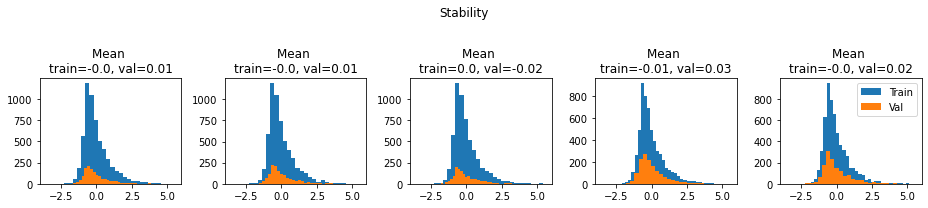

In [61]:
import torch

f, axs = plt.subplots(ncols=5, figsize=(13,3))

for ax in axs.flatten():
    # dataset = ProteinStabilityDataset(base_path / "stability.h5" ,)
    train_set = ProteinStabilityDataset(base_path / "stability_train.h5")

    # X, y = dataset.X, dataset.y

    train_set, val_set = torch.utils.data.random_split(
        train_set,
        lengths=[int(len(train_set) * 0.8), len(train_set) - int(len(train_set) * 0.8)],
    )

    _, y_train = train_set.dataset[train_set.indices] 
    _, y_val = val_set.dataset[val_set.indices]
    
    # ax.hist(y, bins=50, label="Dataset")
    ax.hist(y_train, bins=50, label="Train")
    ax.hist(y_val, bins=50, label="Val")
    
    mean_train = torch.mean(y_train)
    mean_val = torch.mean(y_val)
    ax.set_title(f"Mean \ntrain={round(mean_train.item(), 2)}, val={round(mean_val.item(), 2)}")
    ax.set_xlim([-4, 6])

f.suptitle("Stability")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
ax.legend()
plt.show()

### Diversity

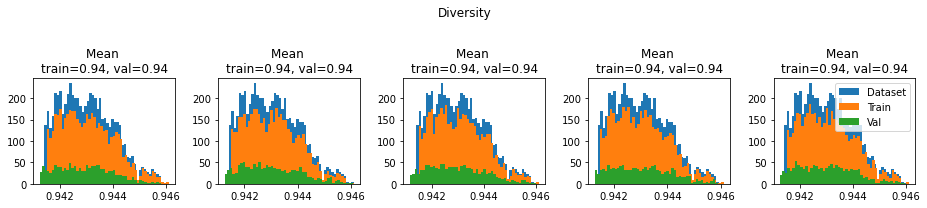

In [65]:
import torch

f, axs = plt.subplots(ncols=5, figsize=(13,3))

for ax in axs.flatten():
    # dataset = ProteinStabilityDataset(base_path / "stability.h5", ret_dict=True)
    train_set = ProteinStabilityDataset(base_path / "stability_train.h5", ret_dict=True)

    # X, y = dataset.X, dataset.y

    train_set, val_set = torch.utils.data.random_split(
        train_set,
        lengths=[int(len(train_set) * 0.8), len(train_set) - int(len(train_set) * 0.8)],
    )

    diversity_dset = pd.read_csv(base_path / "stability_train_diversity.csv")
    diversity_dset_sorted = diversity_dset.sort_values(by="diversity", ascending=True)
    data_train = train_set.dataset[train_set.indices] 
    data_val = val_set.dataset[val_set.indices]
    
    seqs_train = v_bytes_to_str(data_train["sequences"])
    seqs_val = v_bytes_to_str(data_val["sequences"])
    subset_diversity_train = diversity_dset[diversity_dset.sequences.isin(seqs_train)]
    subset_diversity_val = diversity_dset[diversity_dset.sequences.isin(seqs_val)]
    subset_diversity_train = subset_diversity_train.sort_values(by="diversity", ascending=True)
    subset_diversity_val = subset_diversity_val.sort_values(by="diversity", ascending=True)
    
    ax.hist(diversity_dset_sorted.diversity[1000:], bins=50, label="Dataset")
    ax.hist(subset_diversity_train.diversity[900:], bins=50, label="Train")
    ax.hist(subset_diversity_val.diversity[150:], bins=50, label="Val")
    
    mean_train = subset_diversity_train.diversity.mean()
    mean_val = subset_diversity_val.diversity.mean()
    ax.set_title(f"Mean \ntrain={round(mean_train, 2)}, val={round(mean_val, 2)}")

f.suptitle("Diversity")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
ax.legend()
plt.show()